Major definition

"Administrative", "Administrative Duration", "Informational", "Informational Duration", "Product Related" and "Product Related Duration" represent the number of different types of pages visited by the visitor in that session and total time spent in each of these page categories. The values of these features are derived from the URL information of the pages visited by the user and updated in real time when a user takes an action, e.g. moving from one page to another. The "Bounce Rate", "Exit Rate" and "Page Value" features represent the metrics measured by "Google Analytics" for each page in the e-commerce site. The value of "Bounce Rate" feature for a web page refers to the percentage of visitors who enter the site from that page and then leave ("bounce") without triggering any other requests to the analytics server during that session.

The value of "Exit Rate" feature for a specific web page is calculated as for all pageviews to the page, the percentage that were the last in the session. 

The "Page Value" feature represents the average value for a web page that a user visited before completing an e-commerce transaction.

The "Special Day" feature indicates the closeness of the site visiting time to a specific special day (e.g. Mother’s Day, Valentine's Day) in which the sessions are more likely to be finalized with transaction. The value of this attribute is determined by considering the dynamics of e-commerce such as the duration between the order date and very date. For example, for Valentina’s day, this value takes a nonzero value between February 2 and February 12, zero before and after this date unless it is close to another special day, and its maximum value of 1 on February 8. 

The dataset also includes operating system, browser, region, traffic type, visitor type as returning or new visitor, a Boolean value indicating whether the date of the visit is weekend, and month of the

In [1]:
import numpy as np
import pandas as pd

import os
import matplotlib.pyplot as plt
%matplotlib inline


import seaborn as sns

from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

# model evaluation
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

# classifiers
from sklearn.neighbors import KNeighborsClassifier # KNN
from sklearn.linear_model import LogisticRegression # logistic regression
from sklearn.tree import DecisionTreeClassifier # decision tree
from sklearn.ensemble import RandomForestClassifier # random forest
from sklearn.ensemble import GradientBoostingClassifier # gradient boosting

from tqdm import tqdm_notebook
from sklearn.preprocessing import StandardScaler
from sklearn.svm import NuSVC, SVC
from sklearn.metrics import accuracy_score, classification_report,confusion_matrix
pd.options.display.precision = 15

import lightgbm as lgb
import time
import datetime

import json
import ast
from sklearn.model_selection import StratifiedKFold, KFold, RepeatedKFold, train_test_split

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

pd.pandas.set_option('display.max_columns', None)

### 1. EDA: columnar missing vals, distribution and some plots

In [3]:
def missing_data(data):
    '''
    display of missing information per column
    '''
    total = data.isnull().sum()
    percent = (data.isnull().sum()/data.isnull().count()*100)
    tt = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    types = []
    for col in data.columns:
        dtype = str(data[col].dtype)
        types.append(dtype)
    tt['Types'] = types
    return(np.transpose(tt))

def plot_feature_distribution(df1, df2, label1, label2, features):
    '''
    numerical feature ditribution comparator for binary labelled segments
    '''
    i = 0
    sns.set_style('whitegrid')
    plt.figure()
    fig, ax = plt.subplots(3,3,figsize=(10,10))

    for feature in features:
        try:
            i += 1
            plt.subplot(3,3,i)
            sns.distplot(df1[feature], hist=False,label=label1)
            sns.distplot(df2[feature], hist=False,label=label2)
            plt.xlabel(feature, fontsize=9)
            locs, labels = plt.xticks()
            plt.tick_params(axis='x', which='major', labelsize=6, pad=-6)
            plt.tick_params(axis='y', which='major', labelsize=6)
        except:
            continue
    plt.show();

In [4]:
# starting point, read in raw data
df = pd.read_csv('online_shoppers_intention.csv')

# categorical feature coersive conversion
df['SpecialDay'] = df['SpecialDay'].astype('O')
df['OperatingSystems'] = df['OperatingSystems'].astype('O')
df['Browser'] = df['Browser'].astype('O')
df['Region'] = df['Region'].astype('O')
df['TrafficType'] = df['TrafficType'].astype('O')
df['Revenue'] = df['Revenue'].astype(int)

# convenient vars for columns
feature_cols = df.columns.tolist()
feature_cols.remove('Revenue')
feature_obj_cols = df.select_dtypes('O').columns.tolist()
feature_num_cols = [x for x in feature_cols if x not in feature_obj_cols]

#show columnar missing values conditions
missing_data(df)

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
Total,14,14,14,14,14,14,14,14,0,0,0,0,0,0,0,0,0,0
Percent,0.113544201135442,0.113544201135442,0.113544201135442,0.113544201135442,0.113544201135442,0.113544201135442,0.113544201135442,0.113544201135442,0,0,0,0,0,0,0,0,0,0
Types,float64,float64,float64,float64,float64,float64,float64,float64,float64,object,object,object,object,object,object,object,bool,int64


<Figure size 432x288 with 0 Axes>

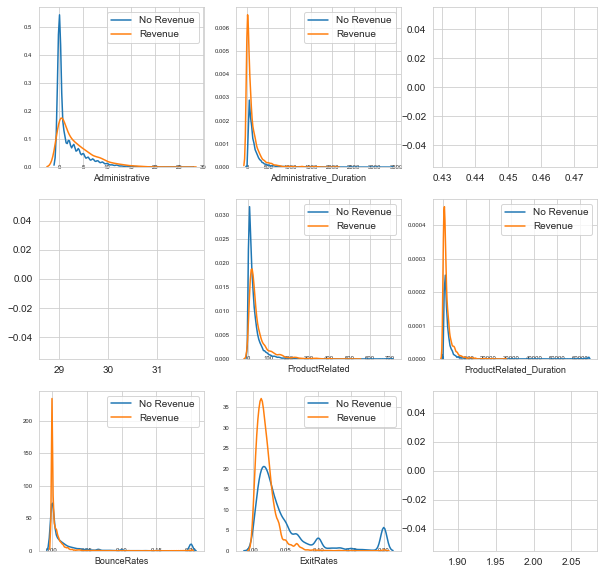

In [5]:
#EDA t0 is non-revenue, t1 is converted to revenue (target)
t0 = df.loc[df['Revenue'] == 0]
t1 = df.loc[df['Revenue'] == 1]

features = df.columns.values[0:9]
plot_feature_distribution(t0, t1, 'No Revenue', 'Revenue', features)

### Build benchmark model, off the shelf version

In [6]:
def benchmark_model(df,target_col):
    '''
    benchmark model, using simple off shelf models
    '''
    
    #fillna on the numerical columns, using mean
    for col in df.select_dtypes(exclude='O').columns.tolist():
        print('fillna on %s'%col)
        df[col].fillna(df[col].mean(),inplace=True)
        
    all_cols = df.columns.tolist()
    all_cols.remove(target_col)
    
    X = pd.get_dummies(df[all_cols])
    y = df[target_col]
    
    #incurred a bit data leakage here due to get dummies, but it's ok due to this is a benchmark
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    
    model_names = ['KNN', 'LR', 'DT', 'RF', 'GBM'] 
    acc = []
    f1 = []

    #using default hyperparameter settings
    knn_clf = KNeighborsClassifier()
    lr_clf = LogisticRegression()
    dt_clf = DecisionTreeClassifier()
    rf_clf = RandomForestClassifier()
    gbm_clf = GradientBoostingClassifier()

    clf_list = [knn_clf,lr_clf,dt_clf,rf_clf,gbm_clf]
    clf_dict = dict(zip(model_names,clf_list))

    for model in model_names:
        clf = clf_dict[model]
        #fit df
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        f1.append(round(f1_score(y_test, y_pred, average='weighted')*100,2))
        acc.append(round(accuracy_score(y_test, y_pred)*100,2))

    accuracy_record = pd.DataFrame({'Model': model_names, 'acc': acc})
    accuracy_record.set_index('Model', inplace=True)
    accuracy_record.loc['avg'] = accuracy_record.mean()

    F1_record = pd.DataFrame({'Model': model_names, 'f1': f1})
    F1_record.set_index('Model', inplace=True)
    F1_record.loc['avg'] = F1_record.mean()

    print(accuracy_record)
    print('\n')
    print(F1_record);

In [7]:
ac = benchmark_model(df,target_col='Revenue')

fillna on Administrative
fillna on Administrative_Duration
fillna on Informational
fillna on Informational_Duration
fillna on ProductRelated
fillna on ProductRelated_Duration
fillna on BounceRates
fillna on ExitRates
fillna on PageValues
fillna on Weekend
fillna on Revenue
                      acc
Model                    
KNN    86.209999999999994
LR     87.829999999999998
DT     86.209999999999994
RF     89.420000000000002
GBM    89.459999999999994
avg    87.825999999999993


                       f1
Model                    
KNN    84.290000000000006
LR     86.390000000000001
DT     86.209999999999994
RF     88.590000000000003
GBM    89.230000000000004
avg    86.942000000000007


### 2. Feature engineering

In [8]:
# create training and testing vars
X = df[feature_cols]
y = df['Revenue']

X_train, X_test, y_train, y_test = train_test_split(df, y, test_size=0.2)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

#fillna on the numerical columns, using mean
for col in feature_num_cols:
    print('fillna on %s'%col)
    X_train[col].fillna(X_train[col].mean(),inplace=True)
    X_test[col].fillna(X_test[col].mean(),inplace=True)

(9864, 18) (9864,)
(2466, 18) (2466,)
fillna on Administrative
fillna on Administrative_Duration
fillna on Informational
fillna on Informational_Duration
fillna on ProductRelated
fillna on ProductRelated_Duration
fillna on BounceRates
fillna on ExitRates
fillna on PageValues
fillna on Weekend


### Dealing with categorical features

In [9]:
df.select_dtypes(include='object')

,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType
0,0,Feb,1,1,1,1,Returning_Visitor
1,0,Feb,2,2,1,2,Returning_Visitor
2,0,Feb,4,1,9,3,Returning_Visitor
3,0,Feb,3,2,2,4,Returning_Visitor
4,0,Feb,3,3,1,4,Returning_Visitor
...,...,...,...,...,...,...,...
12325,0,Dec,4,6,1,1,Returning_Visitor
12326,0,Nov,3,2,1,8,Returning_Visitor
12327,0,Nov,3,2,1,13,Returning_Visitor
12328,0,Nov,2,2,3,11,Returning_Visitor


In [10]:
import category_encoders as ce

'''
rf, xgb can't deal with cat features, need to transform to numerical
lightgbm and CatBoost, can input directly categorical feature。
For lgbm: need to label encoding to find optimal split, better than 1-hot encoding.

* For ordinal features (have latent orders), can use label encoding
* No order information, a few categories (<4), can use 1-hot
* Target encoding (mean/liklihood/impact encoding), can use non-ordinal, >4 categories
'''

def get_categorical_feature(df):
    '''
    deals with categorical columns in df
    shows value counts per col and how much information covered in deciles
    information_coverage: [0,1], as a threshold of captured information percentage
    '''
    df_ctgy = df.select_dtypes(include='O')
    cols = df_ctgy.columns.tolist()
    
    #to return instructions on cat features
    instructions = {}
    
    for col in cols:
        total_types = df_ctgy[col].nunique()
        if total_types <=4:
            instructions[col] = 'one-hot'
    return instructions
    
    

In [11]:
cat_features_instructions = {}

for col in df.select_dtypes(include='O').columns.tolist():
    print(df[col].nunique())

6
10
8
13
9
20
3


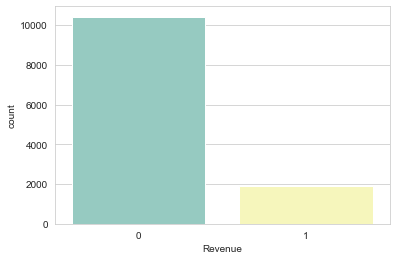

In [12]:
sns.countplot(df['Revenue'], palette='Set3')

In [13]:
### Try Naive Bayes too

In [14]:
from sklearn.preprocessing import StandardScaler
normed_df = df.copy()

scaler = StandardScaler()

for col in feature_num_cols:
    scaled_col = scaler.fit_transform(normed_df[col].values.reshape((-1,1)))
    normed_df[col] = scaled_col

In [15]:
normed_df = pd.get_dummies(normed_df)

In [16]:
# pima1 split
x1 = normed_df.drop(columns='Revenue')
y1 = normed_df['Revenue']
x_train1, x_test1, y_train1, y_test1 = train_test_split(x1, y1, test_size = 0.25, random_state=0)
print(x1.shape, y1.shape)

(12330, 79) (12330,)


In [17]:
from sklearn.model_selection import cross_val_score

search_space = {"RF": {'n_estimators': [25,100,300],
                        'criterion': ['gini', 'entropy'],
                        'bootstrap': [True, False]},
                    "GBM": {'n_estimators': [25,100,300],
                        'max_depth': [3,5,8],
                        'learning_rate': [0.01,0.05,0.2],
                        'loss': ['deviance', 'exponential']}}

def params_tuning(clf_dict,classifier_tag,search_space):
    '''
    input classifier_tag to tune, with targetted search space
    tags include RF, GBM
    '''
    #unpack search space, and classifier, according to tag
    grid_param = search_space[classifier_tag]
    classifier = clf_dict[classifier_tag]
    
    grid_search_obj = GridSearchCV(estimator=classifier, param_grid=grid_param, scoring='accuracy', cv=10,n_jobs=-1)
    #fitting the training set of pima2 (train2)
    grid_search_obj.fit(x_train1, y_train1)
    
    best_parameters = grid_search_obj.best_params_
    best_accuracy = grid_search_obj.best_score_
    
    print('Classifier: '+classifier_tag)
    print('best params found:',best_parameters)
    print('with training accuracy:',best_accuracy)
        
    #fit pima2
    y_pred1 = grid_search_obj.predict(x_test1)
    
    pima2_f1_best = round(f1_score(y_test1, y_pred1, average='weighted')*100,2)
    pima2_acc_best = round(accuracy_score(y_test1, y_pred1)*100,2)
    
    print('best accuracy (test set):', pima2_acc_best)
    print('best f1_Score (test set):', pima2_f1_best)
    
    #print out confusion matrix on testing set
    conf_matrix = confusion_matrix(y_test1, y_pred1)
    print('Confusion matrix on test set:')
    print(conf_matrix)
    
    return grid_search_obj

In [18]:
# K-nearest neighbors, Logistic regression, Decision trees, Random forest, Gradient boosting machine
model_names = ['KNN', 'LR', 'DT', 'RF', 'GBM'] 
pima1_acc = []
pima2_acc = []
pima1_f1 = []
pima2_f1 = []

# --- Your code here ---
#using default hyperparameter settings
knn_clf = KNeighborsClassifier()
lr_clf = LogisticRegression()
dt_clf = DecisionTreeClassifier()
rf_clf = RandomForestClassifier()
gbm_clf = GradientBoostingClassifier()

clf_list = [knn_clf,lr_clf,dt_clf,rf_clf,gbm_clf]
clf_dict = dict(zip(model_names,clf_list))

for model in model_names:
    #looping through each model, in default setting
    clf = clf_dict[model]
    
    #fit pima1
    clf.fit(x_train1, y_train1)
    y_pred1 = clf.predict(x_test1)
    pima1_f1.append(round(f1_score(y_test1, y_pred1, average='weighted')*100,2))
    pima1_acc.append(round(accuracy_score(y_test1, y_pred1)*100,2))
    

accuracy_record = pd.DataFrame({'Model': model_names, 'pima1_acc': pima1_acc})
accuracy_record['acc_mean'] = accuracy_record.mean(axis=1).round(2)
accuracy_record.set_index('Model', inplace=True)
accuracy_record.loc['avg'] = accuracy_record.mean()

F1_record = pd.DataFrame({'Model': model_names, 'pima1_f1': pima1_f1})
F1_record['F1_mean'] = F1_record.mean(axis=1).round(2)
F1_record.set_index('Model', inplace=True)
F1_record.loc['avg'] = F1_record.mean()

print(accuracy_record)
print('\n')
print(F1_record)

pima1_acc            acc_mean
Model                                        
KNN    85.530000000000001  85.530000000000001
LR     87.189999999999998  87.189999999999998
DT     85.790000000000006  85.790000000000006
RF     89.260000000000005  89.260000000000005
GBM    89.170000000000002  89.170000000000002
avg    87.388000000000005  87.388000000000005


                 pima1_f1             F1_mean
Model                                        
KNN    83.629999999999995  83.629999999999995
LR     85.390000000000001  85.390000000000001
DT     85.879999999999995  85.879999999999995
RF     88.340000000000003  88.340000000000003
GBM    88.700000000000003  88.700000000000003
avg    86.388000000000005  86.388000000000005


In [43]:
RF_tuned_clf = params_tuning(clf_dict,'RF',search_space)

NameError: name 'clf_dict' is not defined

In [ ]:
model_names = ['KNN', 'LR', 'DT', 'RF', 'GBM'] 
pima1_acc = []
pima2_acc = []
pima1_f1 = []
pima2_f1 = []


knn_clf = KNeighborsClassifier()
lr_clf = LogisticRegression()
dt_clf = DecisionTreeClassifier()
rf_clf = RandomForestClassifier()
gbm_clf = GradientBoostingClassifier()

clf_list = [knn_clf,lr_clf,dt_clf,rf_clf,gbm_clf]
clf_dict = dict(zip(model_names,clf_list))


In [85]:
GBM_tuned_clf = params_tuning(clf_dict,'GBM',search_space)

KeyboardInterrupt: 

### Cluster the data into groups, using kmeans++


In [44]:
normed_df.head()

NameError: name 'normed_df' is not defined

In [45]:
normed_df[feature_num_cols]

NameError: name 'normed_df' is not defined

In [46]:
# fitting multiple k-means algorithms and storing the values in an empty list
from sklearn.cluster import KMeans

SSE = []
for cluster in range(1,20):
    kmeans = KMeans(n_jobs = -1, n_clusters = cluster, init='k-means++')
    kmeans.fit(normed_df[['BounceRates','ExitRates','OperatingSystems','Revenue']])
    SSE.append(kmeans.inertia_)

# converting the results into a dataframe and plotting them
frame = pd.DataFrame({'Cluster':range(1,20), 'SSE':SSE})
plt.figure(figsize=(12,6))
plt.plot(frame['Cluster'], frame['SSE'], marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')

NameError: name 'normed_df' is not defined